# VU Econometics and Data Science: Case Study
```
Author(s): Jacco Broere
```


### Setup
- Setup config.ini file
- Install necessary packages
- Download and unpack data



In [57]:
# import utility modules
import pandas as pd
import numpy as np
import configparser
import os

# import sweetviz


# import optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# helper functions
from helpers.helper_functions import transform_data, add_actuals
from helpers.helper_classes import AddFeatureNames

# sklearn
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# LightGBM
from lightgbm import LGBMClassifier

# Joblib
from joblib import dump, load

# feature_engine
from feature_engine.selection import DropFeatures, DropConstantFeatures, DropDuplicateFeatures

In [7]:
# Read config.ini file

#TODO: make it work on first try
config = configparser.ConfigParser()
config.read('src/config.ini')

os.chdir(config['PATH']['ROOT_DIR'])

In [8]:
# Read data
raw_train = pd.read_csv(config['PATH']['RAW_TRAIN_DATA'])
raw_test = pd.read_csv(config['PATH']['RAW_TEST_DATA'])
actuals = pd.read_csv(config['PATH']['ACTUALS'])

# Read parameters
SEED = config.getint('PARAMS', 'SEED')
N_COMPONENTS = config.getint('PARAMS', 'N_COMPONENTS')

### Data exploration

In [9]:
# Check total missing values
print(f"Missing values in training set: {raw_train.isna().sum().sum()}")
print(f"Missing values in test set: {raw_test.isna().sum().sum()}")
print(f"Missing values in actuals: {actuals.isna().sum().sum()}")

Missing values in training set: 0
Missing values in test set: 0
Missing values in actuals: 0


### Preprocessing

In [10]:
# Transform data to accesible format and add actuals
train = transform_data(raw_train)
train = add_actuals(train, actuals)
test = transform_data(raw_test)
test = add_actuals(test, actuals)

# get target variable
y_train = train["cancer"]
y_test = test["cancer"]

# Data with 80/20 split
full_df = pd.concat([train, test])
train80, test20 = train_test_split(full_df, test_size=0.2, random_state=SEED)

# Get target for 80/20 split
y_train_80, y_test_20 = train80['cancer'], test20['cancer']

In [87]:
preprocessing_pipe = Pipeline([
    # Step 0:
        # Drop constant and duplicate features
        ('drop_features', DropFeatures(features_to_drop=["cancer"])),
        ('drop_constant', DropConstantFeatures(tol=0.98)),
    
    # Step 1:
        # Apply scaling to data as it is a requirement for the variance maximization procedure of PCA
        ('scaler', StandardScaler()),
])

X_train = preprocessing_pipe.fit_transform(train)
X_test = preprocessing_pipe.fit_transform(test)

X_train_80 = preprocessing_pipe.fit_transform(train80)
X_test_20 = preprocessing_pipe.fit_transform(test20)

### PCA and SparsePCA

In [12]:
pca_pipe = Pipeline([
    # Step 0:
        # Drop constant and duplicate features
        ('drop_features', DropFeatures(features_to_drop=["cancer"])),
        ('drop_constant', DropConstantFeatures(tol=0.98)),
    
    # Step 1:
        # Apply scaling to data as it is a requirement for the variance maximization procedure of PCA
        ('scaler', StandardScaler()),
    # Step 2:
        # Apply PCA
        ('pca', PCA(n_components=N_COMPONENTS, random_state=SEED)),
    # Step 3:
        # Add feature names
        ('add_features_names', AddFeatureNames(prefix="cmpnt_"))
])

def get_spca_pipeline(n_comps = N_COMPONENTS):
    return Pipeline([
        # Step 0:
            # Drop constant and duplicate features
            ('drop_features', DropFeatures(features_to_drop=["cancer"])),
            ('drop_constant', DropConstantFeatures(tol=0.98)),
        
        # Step 1:
            # Apply scaling to data as it is a requirement for the variance maximization procedure of PCA
            ('scaler', StandardScaler()),
        # Step 2:
            # Apply SPCA
            ('spca', SparsePCA(n_components=n_comps, random_state=SEED, alpha=2, max_iter=1000)),
        # Step 3:
            # Add feature names
            ('add_features_names', AddFeatureNames(prefix="cmpnt_"))
    ])

# spca_pipe_30 = get_spca_pipeline()
spca_pipe_40 = get_spca_pipeline(n_comps=40)

In [14]:
# Fit and save SPCA pipelines
# Normal data, spca, 30 features
# spca_pipe_30.fit(train)
spca_filename_30 = config['LOGGING']['PIPE_DIR'] + 'spca_pipe_' + str(N_COMPONENTS) +  'comp.lib'
# dump(spca_pipe30, spca_filename)
spca_pipe_30 = load(spca_filename_30)

In [15]:
# spca_pipe_40.fit(train80)
# spca_filename = config['LOGGING']['PIPE_DIR'] + 'spca_pipe_8020_' + str(50) +  'comp.lib'
# dump(spca_pipe_40.fit(train80)
# , spca_filename)

In [18]:
X_train_pca = pca_pipe.fit_transform(train)
X_train_spca = spca_pipe_30.transform(train)

X_test_pca = pca_pipe.transform(test)
X_test_spca = spca_pipe_30.transform(test)

### Model fitting
#### Implemented models
- Logistic regression
- LightGBM (Gradient Tree Boosting)
- SVC (Support Vector Classifier)

#### Logistic Regression

In [19]:
lr_pipe = Pipeline([
        # Apply logistic regression
        ('logistic_regression', LogisticRegression(random_state=SEED))
])

In [20]:
# Fit and score PCA with Logistic Regression
lr_pipe.fit(X_train_pca, y_train)
print(f"{'Score with Logistic Regression and PCA:':<50} {lr_pipe.score(X_test_pca, y_test)}")

# Fit and score SPCA with Logistic Regression
lr_pipe.fit(X_train_spca, y_train)
print(f"{'Score with Logistic Regression and SPCA:':<50} {lr_pipe.score(X_test_spca, y_test)}")

Score with Logistic Regression and PCA:            0.8235294117647058
Score with Logistic Regression and SPCA:           0.8529411764705882


### LightGBM (Gradient Tree Boosting)

In [26]:
lgbm_pipe = Pipeline([
    # Step 4:
        # Apply LGBM
        ('lgbm_classifier', LGBMClassifier(random_state=SEED))

])

In [27]:
# Fit and score PCA with Logistic Regression
lgbm_pipe.fit(X_train_pca, y_train)
print(f"{'Score with LGBM and PCA:':<50} {lgbm_pipe.score(X_test_pca, y_test)}")

# Fit and score SPCA with Logistic Regression
lgbm_pipe.fit(X_train_spca, y_train)
print(f"{'Score with LGBM and SPCA:':<50} {lgbm_pipe.score(X_test_spca, y_test)}")

Score with LGBM and PCA:                           0.5882352941176471
Score with LGBM and SPCA:                          0.5882352941176471


#### LightGBM tuning with optuna

In [23]:
def objective(trial):
    boost_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart"])
    dataset = trial.suggest_categorical("data", ["spca", "pca"])
    if dataset == 'spca':
        data_cur = X_train_spca
    else:
        data_cur = X_train_pca

    n_leaves = trial.suggest_int('num_leaves', 3, 40)
    n_est = trial.suggest_int('n_estimators', 30, 400)
    max_d = trial.suggest_int('max_depth', 2, 50)

    clf = LGBMClassifier(random_state=SEED,
                        boosting_type = boost_type, 
                        num_leaves = n_leaves,
                        n_estimators = n_est,
                        max_depth = max_d)

    score = cross_val_score(clf, data_cur, y_train, n_jobs = -1, cv = 3)
    f1 = score.mean()
    return f1

In [30]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
print(study.best_trial)

FrozenTrial(number=0, values=[0.7115384615384616], datetime_start=datetime.datetime(2023, 1, 17, 22, 52, 48, 824876), datetime_complete=datetime.datetime(2023, 1, 17, 22, 52, 51, 176861), params={'boosting_type': 'dart', 'data': 'spca', 'num_leaves': 23, 'n_estimators': 232, 'max_depth': 24}, distributions={'boosting_type': CategoricalDistribution(choices=('gbdt', 'dart')), 'data': CategoricalDistribution(choices=('spca', 'pca')), 'num_leaves': IntDistribution(high=40, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=400, log=False, low=30, step=1), 'max_depth': IntDistribution(high=50, log=False, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


No difference between the trials, might be due to a very small training set (score is calculated using cross validation). TODO: change train/test to 80/20 split.

In [35]:
y_pred_test = lr_pipe.predict(X_test_spca)

print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        14
           1       0.80      1.00      0.89        20

    accuracy                           0.85        34
   macro avg       0.90      0.82      0.84        34
weighted avg       0.88      0.85      0.85        34

[[ 9  5]
 [ 0 20]]


In [60]:
def classification_report_extensive(classifier, X_test, y_true):
    y_pred = classifier.predict(X_test)
    print(classification_report(y_true, y_pred))
    conf_mat = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(conf_mat)
    disp.plot()

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        14
           1       0.80      1.00      0.89        20

    accuracy                           0.85        34
   macro avg       0.90      0.82      0.84        34
weighted avg       0.88      0.85      0.85        34



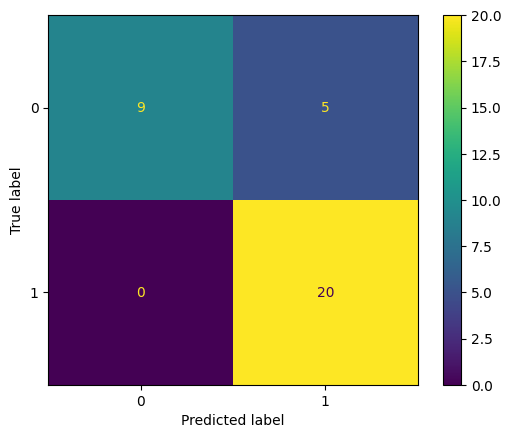

In [61]:
classification_report_extensive(lr_pipe, X_test_spca, y_test)